#  **뉴스 토픽 분류 AI 경진대회**
1. 한글 기사 데이터셋 전처리 - 정규표현식 적극 활용 !!
2. 토큰화 방법 여러 개 적용
3. 빈도에 따라 워드클라우드 생성
---

**Dataset** 
*  https://dacon.io/competitions/official/235747/data
* 국어 📰뉴스 헤드라인을 이용하여, 뉴스의 주제를 분류하는 알고리즘 개발

In [ ]:
!unzip '뉴스 토픽 분류 AI 경진대회.zip' # https://dacon.io/competitions/official/235747/data

unzip:  cannot find or open 뉴스 토픽 분류 AI 경진대회.zip, 뉴스 토픽 분류 AI 경진대회.zip.zip or 뉴스 토픽 분류 AI 경진대회.zip.ZIP.


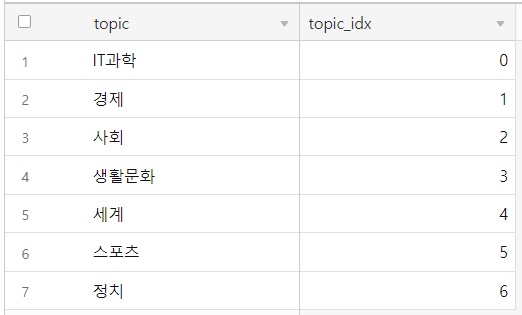

# 1. 기본 설정 + 데이터 불러오기

In [ ]:
import pandas as pd
from glob import glob
import os
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
import os
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import random

import pandas as pd
import re

In [ ]:
from google import colab
colab.drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# go to file
os.chdir('/content/drive/MyDrive')

- SEED 고정, GPU설정

In [ ]:
def seed_everything(seed:int = 1004):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


- 데이터 불러오기

In [ ]:
#파일 불러오기
train = pd.read_csv('train_data.csv', encoding = 'utf-8') #한글의 경우 encoding으로 utf-8, ms949,cp949
test = pd.read_csv('test_data.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('sample_submission.csv', encoding = 'utf-8')

In [ ]:
train

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
...,...,...,...
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1
45652,45652,답변하는 배기동 국립중앙박물관장,2


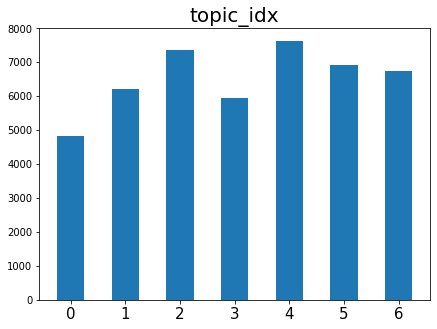

4    7629
2    7362
5    6933
6    6751
1    6222
3    5933
0    4824
Name: topic_idx, dtype: int64


In [ ]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt 
# 데이터 분포 꽤나 balance !! 
feature = train['topic_idx']

plt.figure(figsize=(7,5)) 
plt.title('topic_idx', fontsize=20)
temp = feature.value_counts() # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width=0.5)
plt.xticks(temp.keys(), fontsize=15) 
plt.show()
print(temp) 

# 2. 전처리

## 01. 정규표현식

In [ ]:
#부호를 제거해주는 함수 > 한글, 영어, 숫자, 한자, 공백만 남김
def alpha_num(text):
    return re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9一-龥 ]', '', text)

train['title']=train['title'].apply(alpha_num)

In [ ]:
train[:10]

,index,title,topic_idx
0,0,인천핀란드 항공기 결항휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
5,5,팔레스타인 가자지구서 16세 소년 이스라엘군 총격에 사망,4
6,6,인도 48년 만에 파키스탄 공습테러 캠프 폭격종합2보,4
7,7,美대선 TV토론 음담패설 만회실패 트럼프사과 대신 빌클린턴 공격해 역효과,4
8,8,푸틴 한반도 상황 진전 위한 방안 김정은 위원장과 논의,4
9,9,특검 면죄부 받은 트럼프 스캔들 보도 언론 맹공국민의 적,4


## 02. 불용어처리
- 기본 불용어는 https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt 에 있는 자료로 사용

In [ ]:
with open('kor_stopwords.txt', 'r',encoding='cp949') as f:
    list_file = f.readlines()
stopwords = list_file[0].split(",")


In [ ]:
len(stopwords)

861

In [ ]:
stopwords[:10]

['휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해']

## 03. 토큰화 - 형태소 기준으로

In [ ]:
!pip install konlpy
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
from konlpy.tag import Okt
from konlpy.tag import Kkma
from konlpy.tag import Mecab

okt = Okt()
kkma = Kkma()
mecab = Mecab()

In [ ]:
from konlpy.tag import Mecab

tokenizer = Mecab()

In [ ]:
def remove_stopwords(title):
    final_title = []
    words = tokenizer.morphs(title)
    for word in words:
        if word.strip() not in stopwords:
          final_title.append(word.strip())
    return  " ".join(final_title)


train['title'] = train['title'].apply(alpha_num).apply(remove_stopwords)
test['title'] = test['title'].apply(alpha_num).apply(remove_stopwords)

In [ ]:
train[60:80]

,index,title,topic_idx
60,60,홍콩 서 과격 시위자 제보 최고 1 억 5 천만 원 현상금 걸려,4
61,61,靑 6 회담 틀 완전히 무시 는 게 다,6
62,62,대북 확성기 방송 전면 재 개접 경지 긴장 속 차분 종합,6
63,63,데얀 김치우 OUT 조영욱 IN 서울 과감 한 재건 성과,5
64,64,다당제 효율 적 인 일당 체제 中 공산당 은 망하 지 않 는다,4
65,65,문 대통령 북미 합의 이행 국제 사회 협력 새 시대 헌신,6
66,66,호날두 노 쇼 유 벤 투스 무 책임 거만 비판 수용 어려워,5
67,67,월드컵 태극 전사 산책 닭갈비 피로 해소,5
68,68,北 미사일 발사 정부 개성 공단 체류 인원 500 명 축소 종합,6
69,69,朴 대통령 총선 닷새 만 첫 평가 평소 짧 은 6 분 발언,6


## 추가하고 싶은 작업 : 띄어쓰기 고치기

- `PyKoSpacing`은 띄어쓰기가 되어있지 않은 문장을 띄어쓰기를 한 문장으로 변환해주는 패키지
- PyKoSpacing is based on Deep Learning model trained from large corpus(more than 100 million NEWS articles from Chan-Yub Park)
- https://github.com/haven-jeon/PyKoSpacing
- 계속 시도해보았으니ㅏ tensorflow와 numpy 버전 오류로 실패함 ,,,, ㅠㅠ

In [ ]:
# pip install git+https://github.com/haven-jeon/PyKoSpacing.git

In [ ]:
#from pykospacing import Spacing
#spacing = Spacing()
#newly_train= spacing(train['title']) 

## 04. 워드클라우드
- counter객체로 빈도수 확인해주기

In [ ]:
from collections import defaultdict, Counter
from wordcloud import WordCloud

mecab = Mecab()
token_sentences = [mecab.morphs(text) for text in train['title']]

In [ ]:
counter = Counter()
for title in token_sentences:
  counter.update(title)

In [ ]:
df_list = []
for i in range(7):
  df_list.append(train.loc[train.topic_idx==i])

title_list = []
for i in range(7):
  title_list.append(df_list[i].title.to_numpy())

In [ ]:
filter_pos = ['NNP', 'NNG','SL']  #형태소 분석 -> 품사표 -> 일반명사NNG. 고유명사NNP, 외국어SL

In [ ]:
token_sentence_list = []
for i in range(7):
  titles = title_list[i]
  token_sentences = [word for text in titles for word, pos in mecab.pos(text) if pos in filter_pos]
  token_sentence_list.append(token_sentences)

In [ ]:
counter_list = []
for i in range(7):
  counter = Counter(token_sentence_list[i])    
  counter_list.append(counter)

In [ ]:
!apt-get install fonts-nanum*
!apt-get install fontconfig

(-0.5, 399.5, 199.5, -0.5)

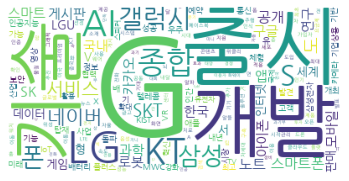

In [ ]:
# index_0 : IT과학
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
wc = WordCloud(font_path = FONT_PATH,
                 background_color = "white")
cloud = wc.generate_from_frequencies(counter_list[0])
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

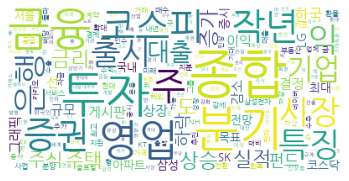

In [ ]:
# index_1 : 경제
wc = WordCloud(font_path = FONT_PATH,
                 background_color = "white")
cloud = wc.generate_from_frequencies(counter_list[1])
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

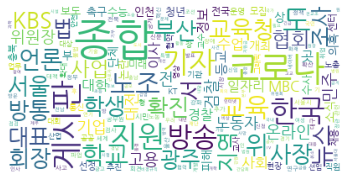

In [ ]:
# index_2 : 사회
wc = WordCloud(font_path = FONT_PATH,
                 background_color = "white")
cloud = wc.generate_from_frequencies(counter_list[2])
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

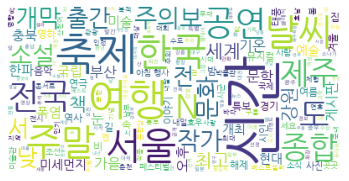

In [ ]:
# index_3 : 생활문화
wc = WordCloud(font_path = FONT_PATH,
                 background_color = "white")
cloud = wc.generate_from_frequencies(counter_list[3])
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

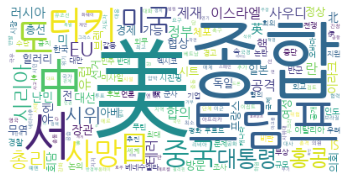

In [ ]:
# index_4 : 세계 (한문 데이터가 많음)
wc = WordCloud(font_path = FONT_PATH,
                 background_color = "white")
cloud = wc.generate_from_frequencies(counter_list[4])
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

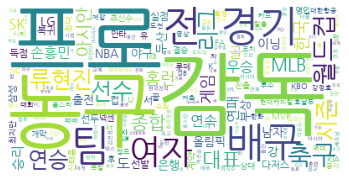

In [ ]:
# index_5 : 스포츠
wc = WordCloud(font_path = FONT_PATH,
                 background_color = "white")
cloud = wc.generate_from_frequencies(counter_list[5])
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

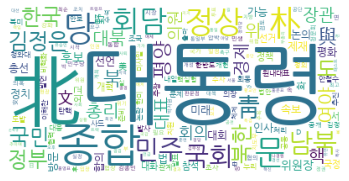

In [ ]:
# index_6 : 정치
wc = WordCloud(font_path = FONT_PATH,
                 background_color = "white")
cloud = wc.generate_from_frequencies(counter_list[6])
plt.imshow(cloud)
plt.axis('off')

#3. 워드 임베딩

In [ ]:
word_set = []
max_len = 0

for d in train['title']:
  word_set = word_set + d.split(' ') # 여기에 토큰화한 데이터가 들어가면 됩니다
  if len(d.split()) > max_len:
    max_len = len(d.split())
  
word_set = set(word_set)



In [ ]:
word_to_idx = {word: i+1 for i, word in enumerate(word_set)}
print(len(word_set))
print(max_len)

31515
21


In [ ]:
def word_to_key(text):
  final_text = []
  for word in text.split():
      final_text.append(word_to_idx[word])
  if len(final_text) < max_len:
    final_text = final_text + [0] * (max_len - len(final_text))
  return final_text


train['word_to_key'] = train['title'].apply(word_to_key)

In [ ]:
train

,index,title,topic_idx,word_to_key
0,0,인천 핀란드 항공기 결항 휴가철 여행객 분통,4,"[19320, 23401, 29997, 28159, 6126, 10537, 1545..."
1,1,실리콘밸리 넘어서 겠 다구 글 15 조 원 들여 美 전역 거점 화,4,"[12631, 4278, 26839, 19032, 15502, 23513, 2639..."
2,2,외무 긴장 완화 해결책 은 미국 경제 전쟁 멈추 는,4,"[29484, 27115, 16041, 23849, 26905, 24715, 293..."
3,3,NYT 클린턴 측근 韓 기업 특수 관계 조명 공과 맞물려 종합,4,"[55, 6672, 25898, 11954, 9295, 6895, 11231, 12..."
4,4,시진핑 트럼프 중미 무역 협상 조속 타결 희망,4,"[23991, 10532, 14655, 11151, 22548, 28025, 228..."
...,...,...,...,...
45649,45649,KB 금융 미국 IB 스티펠 제휴 선진국 시장 공략,1,"[14081, 14418, 24715, 13353, 20835, 24492, 107..."
45650,45650,1 보 서울시 교육청 신종 코로나 확산 개학 연기 휴업 검토,2,"[9795, 8664, 7349, 498, 10056, 10976, 29450, 3..."
45651,45651,게시판 키움증권 2020 키움 영웅전 실전 투자 대회,1,"[19549, 8692, 26460, 17275, 18652, 17109, 1367..."
45652,45652,답변 는 배기동 국립 중앙 박물 관장,2,"[15343, 18893, 26732, 27426, 13619, 7747, 1641..."


In [ ]:
train.shape

(45654, 4)